<center>
    <h1>Tarea 3 ANN</h1>
    <h2>Recurrent Neural Networks</h2>
    <br>
    <h3>Diego Pérez - 201173045-3</h3>
    <h3>Ariel Sanhueza - ROL</h3>
</center>

### Importación de módulos a utilizar durante los experimentos.

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

%matplotlib inline

Using Theano backend.


### RNN en series de tiempo

Se utilizará el dataset International Airline Passengers y el objetivo de la red a entrenar será predecir el número de pasajeros en vuelos internacionales.

#### a) Cargar, dividir y escalar el dataset

Se utilizará el MinMaxScaler en el rango (0,1), es decir, se tomará el menor y mayor valor del dataset y se asignarán como 0 y 1 respectivamente. Todos los demas valores del dataset se escalarán apropiadamente en base al máximo y mínimo.

In [2]:
### LOAD THE DATASET
url = 'http://www.inf.utfsm.cl/~cvalle/international-airline-passengers.csv'
dataframe = pd.read_csv(url, sep=',', usecols=[1], engine='python', skipfooter=3)
dataframe[:] = dataframe[:].astype('float32')

In [3]:
### SPLIT INTO TRAINING AND TEST SETS
df_train, df_test = dataframe[0:96].values, dataframe[96:].values
### SCALE BOTH SETS USING THE SAME MINMAXSCALER
scaler = MinMaxScaler(feature_range=(0, 1)).fit(df_train)
stream_train_scaled = scaler.transform(df_train)
stream_test_scaled = scaler.transform(df_test)

Con los datos ya divididos y escalados, es necesario construir la matriz de entrada para las RNN, a partir de la serie de tiempo.

#### b) Transformar entrada

La siguiente función transforma un vector de entrada (serie de tiempo) considerando un lag como parámentro, para poder ser utilizado como input de las RNN.

In [4]:
def create_dataset(ts, lag=1):
    dataX = np.array([])
    for index in range(lag, len(ts)):
        dataX = np.append(dataX, np.array([ts[index-lag:index]]))
    return dataX.reshape(len(ts)-lag, lag), ts[lag:]

#### c) Crear datsets

Usando lag igual a 3, se crean los dataset de entrenamiento y pruebas.

In [5]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
print('Conjunto de entrenamiento con lag=' + str(lag) + ': ', trainX.shape)
print('Conjunto de pruebas con lag=' + str(lag) + ': ', testX.shape)

Conjunto de entrenamiento con lag=3:  (93, 3)
Conjunto de pruebas con lag=3:  (45, 3)


#### d) Transformación para LSTM

Para poder usar el dataset en una LSTM, necesitamos entradas de la forma [samples, time steps, features].

In [6]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print('Conjunto de entrenamiento con lag=' + str(lag) + ': ', trainX.shape)
print('Conjunto de pruebas con lag=' + str(lag) + ': ', testX.shape)

Conjunto de entrenamiento con lag=3:  (93, 1, 3)
Conjunto de pruebas con lag=3:  (45, 1, 3)


#### e) Entrenamiento

Con las entradas en el formato correcto, generamos el modelo de la red, para luego entrenarla.

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1 (LSTM)                    (None, 4)             128         lstm_input_1[0][0]               
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1)             5           lstm_1[0][0]                     
Total params: 133
____________________________________________________________________________________________________


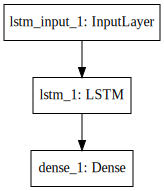

In [7]:
model = Sequential()
model.add(LSTM(4, input_dim=lag, activation='tanh', inner_activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

La inicialización de los pesos es por Gaussiana escalada, como se propone en Glorot, 2010. Para los pesos internos, se usa inicialización ortogonal, donde la matriz obtenida tiene eigenvalues igual a 1, atenuando el problema de vanishing gradient.
Los parámetros por defecto del optimizador Adam son:
* learning rate = 0.001
* beta_1 = 0.9
* beta_2 = 0.999

In [ ]:
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)
model.save('RNN-lag3.h5')

#### f) Predicción y desnormalización.

Se realiza la predicción para los conjuntos de entrenamiento y pruebas, desnormalizando los datos para obtener el error en la escala original.

In [8]:
# LOAD MODEL
model = load_model('RNN-lag3.h5')
# PREDICT SETS
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [9]:
def rmse(y_true, y_pred):
    scaled_pred = scaler.inverse_transform(y_pred)
    scaled_true = scaler.inverse_transform(y_true)
    return np.sqrt(mean_squared_error(scaled_true, scaled_pred[:,0]))

#### g) RMSE

In [10]:
# CALCULATE ROOT MSE
trainScore = rmse(trainY, trainPredict)
print('Train Score: %.2f RMSE' % (trainScore))
testScore = rmse(testY, testPredict)
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 20.78 RMSE
Test Score: 64.11 RMSE


#### h) Graficar

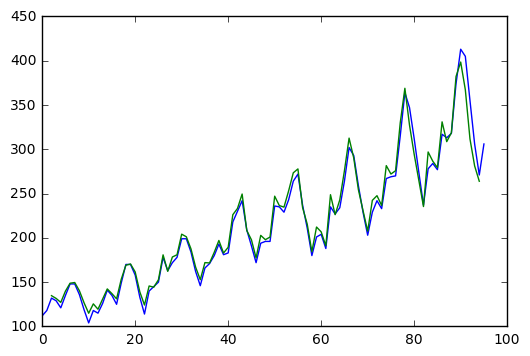

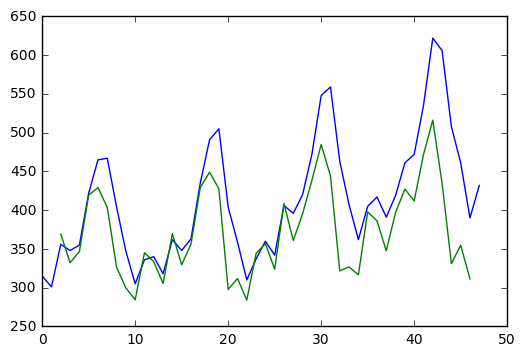

In [10]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_train)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[2:len(trainPredict)+2, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_test)
testPredictPlot[:, :] = np.nan
testPredictPlot[2:len(testPredict)+2, :] = testPredict

import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(0,len(trainPredictPlot)), np.column_stack((df_train, trainPredictPlot)))

plt.figure()
plt.plot(range(0,len(testPredictPlot)), np.column_stack((df_test, testPredictPlot)))

#### h) Determinar bloques con 5-fold CV

In [54]:
def create_model(nb=4):
    model = Sequential()
    model.add(LSTM(nb, input_dim=lag, activation='tanh', inner_activation='sigmoid'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

seed = 7
np.random.seed(seed)

model = KerasRegressor(build_fn=create_model, verbose=0)

param_grid = dict(nb=[4,6,8,10,12], nb_epoch=[100], batch_size=[1])
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_result = grid.fit(trainX, trainY)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.4min finished


MSE LSTM NB=4 : 0.00586441389052
MSE LSTM NB=6 : 0.00656935837371
MSE LSTM NB=8 : 0.00675000006019
MSE LSTM NB=10 : 0.00532124102383
MSE LSTM NB=12 : 0.00723281054501


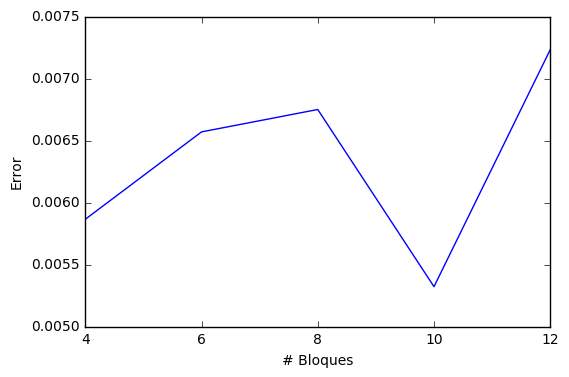

In [67]:
nb=np.array([4,6,8,10,12])
for i in range(0,5):
    print('MSE LSTM NB=' + str(nb[i]) + ' :', grid_result.cv_results_['mean_test_score'][i])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('# Bloques')
ax.set_ylabel('Error')
ax.set_xticks(np.array([0,1,2,3,4]))
ax.set_xticklabels(nb.astype('str'))

ax.plot(np.arange(0, nb.size),grid_result.cv_results_['mean_test_score'])


#### i) Comparación variando el lag

In [11]:
lag_scores = np.array([])
for i in range(1,5):
    model = load_model('RNN-lag' + str(i) + '.h5')
    x, y_true = create_dataset(stream_test_scaled, i)
    x = np.reshape(x, (x.shape[0], 1, x.shape[1]))
    y_pred = model.predict(x)
    lag_scores = np.append(lag_scores, rmse(y_true, y_pred))
print(lag_scores)

[ 63.8134346   56.13454437  64.10595703  71.64993286]


#### j) Comparación con GRU y SimpleRNN

In [12]:
model = load_model('RNN-simple.h5')
simple_score = rmse(testY, model.predict(testX))
model = load_model('RNN-gru.h5')
gru_score = rmse(testY, model.predict(testX))
print(simple_score, gru_score)

74.861 53.9891


#### k) Cambio en la dimensión de entrada

#### l) LSTM con memoria entre batches de tamaño 1

#### m) LSTM con memoria entre batches de tamaño 3

#### n) LSTM apilada con memoria entre batches